
> **ISO2024 INTRODUCTORY SPATIAL 'OMICS ANALYSIS**
>
>
>- HYBRID : TORONTO & ZOOM
>- 9TH JULY 2024 <br>


>**Module 2 : Pre-processing steps**<BR>
>   * A. Understanding your output *
>   * B. Tidying and pre-evaluating your data *

>
>**Instructor : Shamini Ayyadhury**

---

> TOPICS COVERED

* A. Centrality scores *
* B. Ripley's L statistics *

***

In [1]:
### import the following libraries

### Packages for general system functions, miscellaneous operating system interfaces, warning control system
import sys ### general system functions
import os ### miscellaneous operating system interfaces
import warnings ### warning control system
import psutil
warnings.filterwarnings('ignore') ### ignore warnings

### Packages for data manipulation and analysis, data visualization
import pandas as pd ### data manipulation and analysis for tabular data in python
import matplotlib.pyplot as plt ### plotting library for the Python programming language and its numerical mathematics extension NumPy
import seaborn as sns ### data visualization library based on matplotlib (my personal favourite over matplotlib)
import numpy as np ### support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays


In [2]:

sys.path.append('/home/shamini/data/projects/spatial_workshop/')
import pre_processing_fnc as ppf

In [3]:
### its sometimes useful to assign the file names or paths to variables to avoid typing errors

### path variables
data_dir = '/home/shamini/data1/data_orig/data/spatial/xenium/10xGenomics/' ### data directory
os.makedirs(data_dir+'mice_AD_model/wt/module6', exist_ok=True) ### create a new directory for saving files (but checks if the directory already exists)


### object variables
datasets_to_use = 'mice_AD_model/wt/xenium_out/' ### the name of the dataset to use
features_filepath = 'cell_feature_matrix.h5'
cells_filename = 'cells.parquet'
transcripts_filename = 'transcripts.parquet'
metrices_filename = 'metrics_summary.csv'


ppf.get_memory_usage() ### monitor memory usage

'Memory usage: 582.86 MB'

In [6]:

### we will load 3 files here: cell_feature_matrix.h5, cells.parquet and transcripts.parquet
### We will check the parquet file to ensure that the string values are not in bytes format and if they are to convert them back to string
df_cell = ppf.check_parquet(os.path.join(data_dir+datasets_to_use ,cells_filename))
df_transcript = ppf.check_parquet(os.path.join(data_dir+datasets_to_use, transcripts_filename))
df_metric = pd.read_csv(os.path.join(data_dir+datasets_to_use, metrices_filename))

ppf.get_memory_usage() ### monitor memory usage

'Memory usage: 4440.82 MB'

Analyze transcript QC

In [7]:


processed_data = ppf.process_data(df_transcript) ### we process and assign the output to an object called processed_data
del df_transcript ### we delete the original transcript dataframe to save memory

ppf.get_memory_usage() ### monitor memory usage

'Memory usage: 5446.76 MB'

In [8]:
processed_data.head()
### note the additional columns added to the processed_data dataframe : group and binary


,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,fov_name,nucleus_distance,group,binary
0,281474976710757,chhhnfkp-1,0,BLANK_0028,453.595123,872.884766,16.262711,5.387139,A1,0.490234,neg_probes,assigned
1,281474976710923,chhkgjhm-1,0,BLANK_0020,460.812592,872.894104,16.546083,7.981221,A1,0.670534,neg_probes,assigned
2,281474976710928,chhggofm-1,1,BLANK_0039,479.464355,877.083496,18.179480,13.063369,A1,0.000000,neg_probes,assigned
3,281474976711241,chfgmodb-1,0,NegControlCodeword_0513,539.307312,873.435242,19.953156,6.050564,A1,0.420708,neg_probes,assigned
4,281474976711333,UNASSIGNED,0,NegControlProbe_00009,46.383392,741.893066,12.222447,6.111165,A1,297.139221,neg_probes,unassigned


In [9]:
"""
The cleaned data is then used to create the gene matrix, control matrix, counts matrix and cell centroid matrix 
Here, it involves removing low quality transcripts and assigning the transcripts to the cells based on the cell segmentation from the standard xenium clear_output
We still keep the negative control values as a separate matrix

However the 3 matrices that we will bring forward to the next lesson are
1. gene matrix
2. counts matrix
3. cell centroid matrix
"""

df_counts, transcripts_df, gene_mtx, neg_mtx, centroids = ppf.clean_processed_tf(processed_data)

ppf.get_memory_usage() ### monitor memory usage

'Memory usage: 5949.45 MB'

In [11]:
df_counts.to_csv(data_dir+'mice_AD_model/wt/module6/df_counts.csv', index=True)
gene_mtx.to_csv(data_dir+'mice_AD_model/wt/module6/gene_mtx.csv', index=True)
neg_mtx.to_csv(data_dir+'mice_AD_model/wt/module6/neg_mtx.csv', index=True)
centroids.to_csv(data_dir+'mice_AD_model/wt/module6/centroids.csv', index=True)
transcripts_df.to_csv(data_dir+'mice_AD_model/wt/module6/transcripts_df.csv', index=True)

ppf.get_memory_usage() ### monitor memory usage

'Memory usage: 5994.52 MB'

In [13]:
import scanpy as sc ### scanpy is a package for single-cell analysis in python

In [14]:
adata = sc.AnnData(X=gene_mtx, var=pd.DataFrame(index=gene_mtx.columns.values))

df_counts = df_counts[df_counts.index.isin(gene_mtx.index)]

df_counts = df_counts.reindex(gene_mtx.index)
adata.obs = df_counts.copy()
    
centroids = centroids.reindex(adata.obs.index)
adata.obs[['x_location', 'y_location']] = centroids[['centroid_x', 'centroid_y']].values

gene_mtx_bool = gene_mtx > 0
n_cells = gene_mtx_bool.sum(axis=0)
n_genes = gene_mtx_bool.sum(axis=1)

adata.var['n_cells'] = n_cells
adata.obs['n_genes'] = n_genes

sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_counts=9)



In [15]:
n_genes = gene_mtx_bool.sum(axis=1)
adata.obs['n_genes'] = n_genes

'Memory usage: 6159.04 MB'

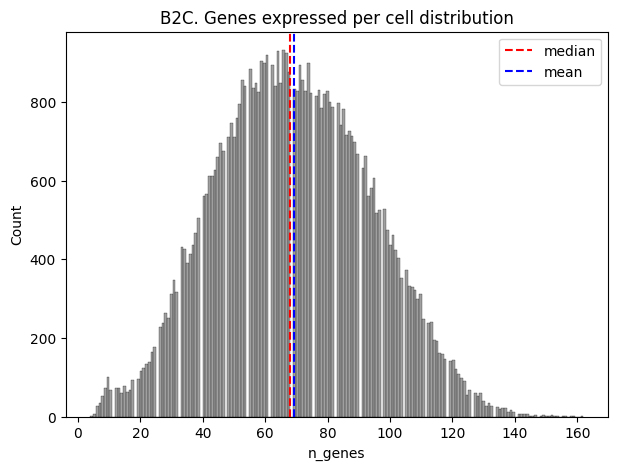

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(7, 5))


median = np.median(adata.obs['n_genes'])
mean = np.mean(adata.obs['n_genes'])

adata.uns['n_genes_med'] = median
adata.uns['n_genes_mean'] = mean

### first look at counts distribution
ax = sns.histplot(adata.obs['n_genes'], bins=180, color='gray')
ax.axvline(median, color='red', linestyle='--', label='median')
ax.axvline(mean, color='blue', linestyle='--', label='mean')
ax.legend()
ax.set_title('B2C. Genes expressed per cell distribution')



ppf.get_memory_usage() ### monitor memory usage

In [17]:
### Always remember to save the coordinates of the spatial data in the adata object into the uns and obsm slots. Many methods call the spatial coordinates from these slots

adata.obsm['spatial'] = adata.obs[['x_location', 'y_location']].values
adata.uns['spatial'] = {'spatial' : adata.obsm['spatial'].copy()}

In [18]:
### save your adata
adata.raw = adata
adata.write(data_dir+'mice_AD_model/wt/module6/adata_wt.h5ad')